In [1]:
# Run this cell first to import all required libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

print("TensorFlow version:", tf.__version__)
print("Libraries imported successfully!")

TensorFlow version: 2.18.0
Libraries imported successfully!


In [2]:
class DroneEnvironment:
    def __init__(self, size=(50, 50, 30), num_obstacles=5):
        """Smaller environment for initial testing"""
        self.size = size
        self.obstacles = self._generate_obstacles(num_obstacles)
        self.start = np.array([0, 0, 0])
        self.goal = np.array([size[0]-1, size[1]-1, size[2]-1])
        
    def _generate_obstacles(self, num_obstacles):
        """Generate random obstacles"""
        obstacles = []
        for _ in range(num_obstacles):
            obstacle = np.array([
                np.random.randint(0, self.size[0]),
                np.random.randint(0, self.size[1]),
                np.random.randint(0, self.size[2])
            ])
            obstacles.append(obstacle)
        return np.array(obstacles)
    
    def is_collision(self, position):
        """Check for collisions"""
        for obstacle in self.obstacles:
            if np.all(np.abs(position - obstacle) < 3):
                return True
        return False
    
    def get_state(self, position):
        """Get state representation"""
        normalized_pos = position / np.array(self.size)
        normalized_goal = self.goal / np.array(self.size)
        obstacle_distances = np.linalg.norm(self.obstacles - position, axis=1)
        min_obstacle_dist = np.min(obstacle_distances) / np.max(self.size)
        return np.concatenate([normalized_pos, normalized_goal, [min_obstacle_dist]])

# Test the environment
env = DroneEnvironment()
print("Environment created!")
print("Environment size:", env.size)
print("Number of obstacles:", len(env.obstacles))
print("Obstacle positions:\n", env.obstacles)

Environment created!
Environment size: (50, 50, 30)
Number of obstacles: 5
Obstacle positions:
 [[ 7 40 24]
 [ 3  5 12]
 [ 3 37 11]
 [41 49 17]
 [10 42  7]]


In [25]:
class PathPlanningModel:
    def __init__(self, input_dim=7, action_dim=3):
        """Initialize the model with state and action dimensions"""
        self.model = self._build_model(input_dim, action_dim)
        
    def _build_model(self, input_dim, action_dim):
        """Build neural network architecture"""
        model = Sequential([
            Dense(64, activation='relu', input_dim=input_dim),
            Dropout(0.1),
            Dense(128, activation='relu'),
            Dropout(0.1),
            Dense(64, activation='relu'),
            Dense(action_dim, activation='tanh')
        ])
        
        model.compile(optimizer='adagrad', loss='mse')
        return model
    
    def predict_action(self, state):
        return self.model.predict(state.reshape(1, -1))[0]
    
    def train(self, states, actions, epochs=30, batch_size=32):
        return self.model.fit(states, actions, epochs=epochs, 
                            batch_size=batch_size, verbose=1)

# Test the model
model = PathPlanningModel()
print("Model created!")
model.model.summary()

Model created!


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                     │ (None, 64)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,283 (67.51 KB)

 Trainable params: 17,283 (67.51 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
class DronePathPlanner:
    def __init__(self, environment):
        self.env = environment
        self.model = PathPlanningModel()
        
    def generate_training_data(self, num_episodes=100, steps_per_episode=50):
        """Generate training data - reduced episodes for testing"""
        states = []
        actions = []
        
        for episode in range(num_episodes):
            current_pos = self.env.start.copy()
            
            for _ in range(steps_per_episode):
                state = self.env.get_state(current_pos)
                direction = self.env.goal - current_pos
                action = direction / np.linalg.norm(direction)
                action += np.random.normal(0, 0.1, size=3)
                action = np.clip(action, -1, 1)
                
                states.append(state)
                actions.append(action)
                
                new_pos = current_pos + action * 3  # Smaller step size
                if not self.env.is_collision(new_pos):
                    current_pos = new_pos
                
                if np.all(np.abs(current_pos - self.env.goal) < 3):
                    break
                    
            if episode % 10 == 0:
                print(f"Generated episode {episode}/{num_episodes}")
                    
        return np.array(states), np.array(actions)
    
    def train(self, num_episodes=100):
        """Train with fewer episodes initially"""
        print("Generating training data...")
        states, actions = self.generate_training_data(num_episodes)
        print("Training model...")
        return self.model.train(states, actions)
    
    def plan_path(self, start=None, max_steps=100):
        if start is None:
            current_pos = self.env.start.copy()
        else:
            current_pos = start.copy()
            
        path = [current_pos.copy()]
        
        for step in range(max_steps):
            state = self.env.get_state(current_pos)
            action = self.model.predict_action(state)
            
            new_pos = current_pos + action * 3
            if not self.env.is_collision(new_pos):
                current_pos = new_pos
                path.append(current_pos.copy())
            
            if np.all(np.abs(current_pos - self.env.goal) < 3):
                print(f"Goal reached in {step} steps!")
                break
                
        return np.array(path)

# Create planner instance
planner = DronePathPlanner(env)
print("Path planner created!")

Path planner created!


In [27]:
# Train the planner
training_history = planner.train(num_episodes=100)
print("Training completed!")

Generating training data...
Generated episode 0/100
Generated episode 10/100
Generated episode 20/100
Generated episode 30/100
Generated episode 40/100
Generated episode 50/100
Generated episode 60/100
Generated episode 70/100
Generated episode 80/100
Generated episode 90/100
Training model...
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3998
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2150
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1297
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0812
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0518
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0375
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0280
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225
Epoch 9/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217
Epoch 10/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187
Epoch 11/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Goal reached in 24 steps!


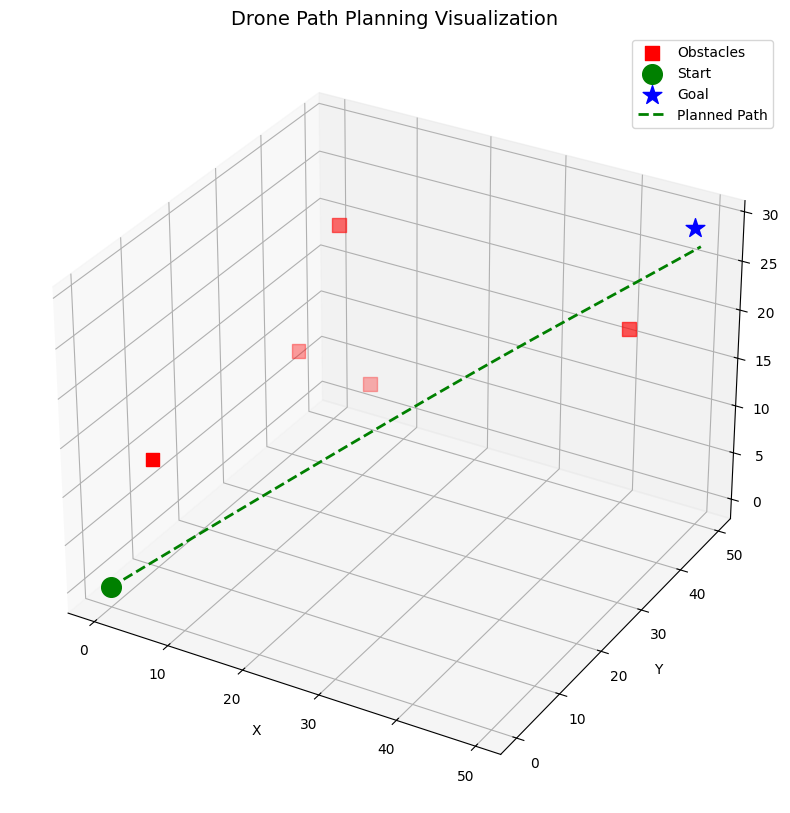

In [28]:
def visualize_path(env, path):
    """Visualize the environment and planned path"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot obstacles
    ax.scatter(env.obstacles[:, 0], env.obstacles[:, 1], env.obstacles[:, 2], 
              c='red', marker='s', s=100, label='Obstacles')
    
    # Plot start and goal
    ax.scatter(*env.start, c='green', marker='o', s=200, label='Start')
    ax.scatter(*env.goal, c='blue', marker='*', s=200, label='Goal')
    
    # Plot path
    path = np.array(path)
    ax.plot(path[:, 0], path[:, 1], path[:, 2], 'g--', linewidth=2, label='Planned Path')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(fontsize=10)
    plt.title("Drone Path Planning Visualization", fontsize=14)
    plt.show()

# Plan and visualize a path
path = planner.plan_path()
visualize_path(env, path)

In [29]:
def analyze_path(env, path):
    """Analyze the planned path"""
    path_length = np.sum(np.linalg.norm(np.diff(path, axis=0), axis=1))
    straight_line_dist = np.linalg.norm(env.goal - env.start)
    path_efficiency = straight_line_dist / path_length * 100
    
    min_obstacle_dist = float('inf')
    for pos in path:
        distances = np.linalg.norm(env.obstacles - pos, axis=1)  # Corrected 'positions' to 'pos'
        min_dist = np.min(distances)
        min_obstacle_dist = min(min_obstacle_dist, min_dist)
    
    print(f"Path Analysis:")
    print(f"Total path length: {path_length:.2f} units")
    print(f"Straight-line distance: {straight_line_dist:.2f} units")
    print(f"Path efficiency: {path_efficiency:.2f}%")
    print(f"Minimum distance to obstacles: {min_obstacle_dist:.2f} units")

# Analyze the path
analyze_path(env, path)


Path Analysis:
Total path length: 75.18 units
Straight-line distance: 75.12 units
Path efficiency: 99.92%
Minimum distance to obstacles: 9.16 units
